#Quarter Back Analysis using PySpark

##What it does:
- Extracts CSV files from folder fbl_players and loads it into an RDD ([Resilient Distributed Datasets](https://spark.apache.org/docs/1.6.0/api/java/org/apache/spark/rdd/RDD.html))
- Converts RDD to DataFrame for SparkSQL Queries. [More info](https://spark.apache.org/docs/1.5.2/api/python/pyspark.sql.html#pyspark.sql.DataFrame)

In [1]:
from pyspark.sql.types import *


#Extract CSV files from folder and store as RDD
players = sc.textFile("fbl_players/QB*.csv")

#Create fields/column headers for data frame
fields =[
    StructField("player", StringType(), True),
    StructField("opposition", StringType(), True),
    StructField("passing_yds",IntegerType(),True),
    StructField("passing_td",IntegerType(),True),
    StructField("passing_int",IntegerType(),True),
    StructField("rushing_yds",IntegerType(),True),
    StructField("rushing_td",IntegerType(),True),
    StructField("receving_yds",IntegerType(),True),
    StructField("receiving_td",IntegerType(),True),
    StructField("misc_fumTD",IntegerType(),True),
    StructField("misc_2pt",IntegerType(),True),
    StructField("fum_lost",IntegerType(),True),
    StructField("fantasy_points",FloatType(),True),
    StructField("week",IntegerType(),True),
    StructField("game_year",IntegerType(),True),
]

#Define schema with column headers for data frames
schema = StructType(fields)

#RDD has data from csv file where 0 is represented by '-'
#map allows the replacement of the '-' with 0 then transforms numerical values from character to integer values
players =  players.map(lambda a: a.replace("-","0")).map(lambda a: a.split(",")).map(lambda a: (a[0],a[1],int(a[2]),int(a[3]),int(a[4]),int(a[5]),int(a[6]),int(a[7]),int(a[8]),int(a[9]),int(a[10]),int(a[11]),float(a[12]),int(a[13]),int(a[14])))

#Create Data frame with Schema and RDD 
playersDF = sqlContext.createDataFrame(players,schema)

#Register temporary table for SparkSQL to perform SQL queries
playersDF.registerTempTable("players")

In [2]:
#Sample Queries to analyze data using SparkSQL and temporary table players

sqlContext.sql("""
Select player, sum(passing_yds) as total_passing_yds 
from players 
group by player order by total_passing_yds desc
""").show()

player_name = "Russell Wilson"
target_qb = ["'Russell Wilson'","'Blake Bortles'","'Colin Kaepernick'","'Tyrod Taylor'"]

sqlContext.sql("Select player, opposition, passing_yds,rushing_yds, \
  game_year, week from players where player in ({}) and game_year=2015\
  order by player, week".format(",".join(target_qb))).show()


sqlContext.sql("Select player, opposition, passing_yds,rushing_yds, \
  game_year, week from players where player like '%{}%' and game_year=2015\
  order by player, week".format(player_name)).show()

#Extract Russell Wilson's data for plot
player_stats = sqlContext.sql("Select player, opposition, passing_yds,rushing_yds, \
  game_year, week from players where player like '%{}%' and game_year=2015\
  order by player, week".format(player_name))

+------------------+-----------------+
|            player|total_passing_yds|
+------------------+-----------------+
|        Drew Brees|            11730|
|    Peyton Manning|            11728|
|         Matt Ryan|            10960|
|     Philip Rivers|            10881|
|  Matthew Stafford|            10517|
|         Tom Brady|            10151|
|Ben Roethlisberger|            10125|
|       Eli Manning|             9834|
|       Andrew Luck|             9648|
|        Joe Flacco|             9503|
|       Andy Dalton|             9452|
|    Ryan Tannehill|             9304|
|     Aaron Rodgers|             8408|
|    Russell Wilson|             8265|
|        Alex Smith|             8151|
|         Tony Romo|             8084|
|  Colin Kaepernick|             7895|
|        Jay Cutler|             7664|
|     Carson Palmer|             7637|
|        Cam Newton|             7584|
+------------------+-----------------+

+----------------+----------+-----------+-----------+---------+

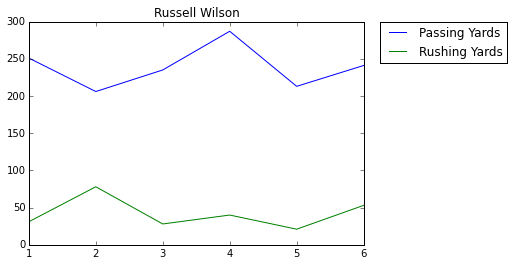

In [4]:
from matplotlib import pyplot as plt

#Extract data from SQL queries for matlibplot
x = player_stats.map(lambda a: a.week).collect() 
y = player_stats.map(lambda a: a.passing_yds).collect()
y2 = player_stats.map(lambda a: a.rushing_yds).collect()

fig1 = plt.figure()
plt.title(player_name)
plt.plot(x,y, label="Passing Yards")
plt.plot(x,y2, label="Rushing Yards")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig1.show()